In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

!pip install varname
import varname
import os
import time
import math
import pickle
import datetime

In [ ]:
#this stuff was added to invidual classses and functions that needed it
#don't worry about it

#activity labels as defined in activity_labels.txt
#activity_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']
#activity_labels = {k:v for k,v in enumerate(activity_labels, start=1)}
#print(activity_labels)

# Data Processing

## Data loading
*  If you are running this on a local machine, don't worry about this part.
*  If you are using google colab, please specify the path to your training/testing files here. 
*  If you are not uisng google drive to store files, please add a new cell to specify the location of the training data.

In [3]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive/')

  colab_folder = '/content/gdrive/My Drive/Colab Notebooks/ecps205_final_project'
except:
  colab_folder='os.path.abspath(os.getcwd())'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## **Data Processesing**

In [4]:
#load data
def load_data(path):
    data = pd.read_csv(path, header=None, delim_whitespace=True)
    return data.values

def load_set(path, x, y):
    data = load_data(path+x)
    labels = load_data(path+y)
    return data, labels

#reduce the labels by 1 to match with the activity_labels and also to start labels at 0 to 11 instead of from 1 to 12
def adjust_labels (labels):
    for i in range(len(labels)):
        labels[i][0] -= 1
    return labels

train_data, train_labels = load_set(colab_folder + '/HAPT Data Set/Train/', 'X_train.txt', 'y_train.txt')
test_data, test_labels = load_set(colab_folder + '/HAPT Data Set/Test/', 'X_test.txt', 'y_test.txt')

print('adjusting labels...')
train_labels = adjust_labels(train_labels);
test_labels = adjust_labels(test_labels);

reshaping data...
adjusting labels...


In [5]:
#takes an array of data as an input
class PlotData():
    activity_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']
    def __init__(self, data, labels, name):
        self.data = data
        self.labels = labels
        self.name = name
        
    #start = starting index (inclusive) for data to create plots for
    #end = ending index (exclusive) for data to create plots for
    #index starts at zero but when looking at the .txt files, index starts at 1, take that into account when choosing data points to plot
    def plot_data(self, start, end='', save=False):
        if end == '':
            r = 1 #range of data
        else:
            r = end-start #range of data
        if r == 1 or end == '':
            fig, ax = plt.subplots(r ,figsize=(20,5))
            ax.plot(self.data[start])
            ax.grid()
            ax.set(xlabel='Timestep', ylabel='Processed Data', title=f'{self.activity_labels[self.labels[start][0]]} (label: {self.labels[start][0]+1}) (row: {start})')
        else:
            for i in range(r):
                fig, ax = plt.subplots(r ,figsize=(20,5*(r)))
                d_i = i+start
                ax[i].plot(self.data[d_i])
                ax[i].grid()
                ax[i].set(xlabel='Timestep', ylabel='Processed Data', title=f'{self.activity_labels[self.labels[d_i][0]]} (label: {self.labels[d_i][0]+1}) (row: {d_i})')
        fig.subplots_adjust(hspace=1)
        if save:
            plt.savefig(colab_folder + f"/plots/train_test/{self.name}_{start}-{end}.png")
        plt.show()

In [ ]:
#generate plots to vizulaize the input train/test data
p_train = PlotData(train_data, train_labels, varname.nameof(train_data))
p_train.plot_data(88, save=True)
p_train.plot_data(162, save=True)
p_train.plot_data(152, save=True)
p_train.plot_data(204, save=True)
p_train.plot_data(194, save=True)
p_train.plot_data(234, save=True)
p_train.plot_data(200, save=True)
p_train.plot_data(923, save=True)
p_train.plot_data(2245, save=True)
p_train.plot_data(2230, save=True)
p_train.plot_data(2567, save=True)
p_train.plot_data(2260, save=True)
#p_test = PlotData(test_data, test_labels)
#p_test.plot_data(500)

# **Model**

## Prediction function

In [6]:
#print out n number (pred_range) of predicted values and compare them with test labels
def predict(pred_range, pred_outs, test_labels):
    activity_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']

    #test if the label matches the prediction
    false_pred = 0
    true_pred = 0
    #look at predictions for the first 25 values
    for i in range(pred_range):
        if not (0 <= pred_outs[i] or pred_outs[i] <= 11):
            print('prediction out of bounds')
            break

        print(f'Test label: {activity_labels[test_labels[i][0]]}')
        print(f'Predicted label:{activity_labels[pred_outs[i]]}')

        if pred_outs[i]==test_labels[i][0]:
            print('true\n')
            true_pred += 1
        else:
            print('false\n')
            false_pred += 1
    print(f'False predictions:{false_pred}')
    print(f'True predictions:{true_pred}')
    print(f'Prediction accuraccy for first {pred_range} values: {true_pred/pred_range}')

## Model

In [21]:
#get time of epochs to record training time
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
def run_model(test_data, test_labels, train_data, train_labels, filters, kernel_size, dropout, dense, epochs, activation_function='relu', it='', show_predict=True, save_model=False):
    save_path = f'filters-{filters}_kernel_size-{kernel_size}_dropout-{dropout}_dense-{dense}_epochs-{epochs}_it-{it}'
    saved_model_path = f'{colab_folder}/saved_models\\{save_path}'
    current_directory = os.path.abspath(os.getcwd())
    training_time=-1   #denotes pre-trained model being loaded from saved models
    history=-1 #denotes pre-trained model being loaded from saved models
    
    if os.path.exists(os.path.join(current_directory,saved_model_path)) :
        print(f'found saved model, loading from: {saved_model_path}')
        model = models.load_model(saved_model_path)
        test_loss,test_acc = model.evaluate( test_data, test_labels, verbose=2)
    else:
        #input shape
        timesteps = train_data.shape[1] #561 timesteps
        features = 1 #train_data.shape[2] #1 feature

        #model
        model = models.Sequential()
        model.add(layers.Reshape((timesteps, features), input_shape=(timesteps,)))
        model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, activation='relu', input_shape=(timesteps, features)))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, activation='relu'))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, activation='relu'))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(dropout))
        model.add(layers.Flatten())
        model.add(layers.Dense(dense, activation='relu'))
        model.add(layers.Dense(dense, activation='relu'))
        model.add(layers.Dense(12, activation=activation_function))
        model.summary()

        # Compile the model
        model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
        #evaluate model
        test_loss,test_acc = model.evaluate(test_data, test_labels, verbose=2)

        if show_predict:
            #predict
            pred_outs = model.predict_classes(test_data)
            #display predictions
            predict(10, pred_outs, test_labels)

        #train the model
        #set up timing callback
        time_callback = TimeHistory()

        history = model.fit(train_data, 
                  train_labels, 
                  epochs=epochs, 
                  validation_data=(test_data, test_labels),
                callbacks=[time_callback])

        test_loss,test_acc = model.evaluate( test_data, test_labels, verbose=2)

        training_time = sum(time_callback.times)
        
        if save_model:
            model.save(saved_model_path)
        
        history = history.history
    return test_loss, test_acc, training_time, history

In [23]:
run_model(test_data, test_labels, train_data, train_labels, filters=32, kernel_size=3, dropout=0.5, dense=128, epochs=3, activation_function='softmax', it='', show_predict=False, save_model=False)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 561, 1)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 559, 32)           128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 279, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 277, 32)           3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 138, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 136, 32)           3104      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 68, 32)           

KeyboardInterrupt: ignored

# **Tester**

In [19]:
def time_unit_string(time):
    return f"Total training time: {math.floor(time/1)}s {math.floor(time%1 * 1000)}ms {math.ceil(time%(1/1000)*1000)}us"

class RunTests: 
    #init the default model parameters
    #n_tests is the number of tests to run for each parameter
    #d_name is the prefix name that will be prepended to each .pickle file generated by this function
    def __init__(self, n_tests, d_filters, d_kernel_size, d_dropout, d_dense, d_activation_function, d_epochs, d_name):
        self.n_tests = n_tests
        self.d_filters = d_filters
        self.d_kernel_size = d_kernel_size
        self.d_dropout = d_dropout
        self.d_epochs = d_epochs
        self.d_dense = d_dense
        self.d_name = d_name
        self.d_activation_function = d_activation_function
        self.folder = f"{d_name}-tests-{n_tests}_filters-{d_filters}_kernel-{d_kernel_size}_dropout-{d_dropout}_epochs-{d_epochs}_dense-{d_dense}_activation-{d_activation_function}"
        if not os.path.exists(f'{colab_folder}/saved_data/{self.folder}'):
          os.mkdir(f'{colab_folder}/saved_data/{self.folder}')
        
    #tests a specific parameter n_tests number of times
    #the parameter should be specified as a list, see examples below
    #!!only choose one parameter at a time!!
    def test_param(self, filters=None, kernel_size=None, dropout=None, dense=None, epochs=None, activation_function=None, save=True):    
        if isinstance(filters,list):
            data = filters
            data_type = 'filters'
            kernel_size = self.d_kernel_size
            dropout=self.d_dropout
            epochs=self.d_epochs
            dense=self.d_dense
            activation_function=self.d_activation_function
        elif isinstance(kernel_size,list):
            data = kernel_size
            data_type = 'kernel_size'
            dropout=self.d_dropout
            epochs=self.d_epochs
            filters = self.d_filters
            dense=self.d_dense
            activation_function=self.d_activation_function
        elif isinstance(dropout,list):
            data = dropout
            data_type = 'dropout'
            kernel_size = self.d_kernel_size
            epochs=self.d_epochs
            filters = self.d_filters
            dense=self.d_dense
            activation_function=self.d_activation_function
        elif isinstance(dense, list):
            data=dense
            data_type='dense'
            kernel_size = self.d_kernel_size
            dropout=self.d_dropout
            epochs=self.d_epochs
            filters = self.d_filters
            activation_function=self.d_activation_function
        elif isinstance(epochs,list):
            data = epochs
            data_type = 'epochs'
            kernel_size = self.d_kernel_size
            dropout=self.d_dropout
            filters = self.d_filters
            dense=self.d_dense
            activation_function=self.d_activation_function
        elif isinstance(activation_function, list):
          data = activation_function
          data_type = 'activation_function'
          kernel_size = self.d_kernel_size
          dropout=self.d_dropout
          epochs=self.d_epochs
          filters = self.d_filters
          dense=self.d_dense
        else:
            print('no data type selected, running default...')
            data = [1]
            data_type = 'default' 
            kernel_size = self.d_kernel_size
            dropout=self.d_dropout
            epochs=self.d_epochs
            filters = self.d_filters
            dense=self.d_dense
            activation_function=self.d_activation_function
            
        model_test_data = []
        for index, item in enumerate(data):
            model_test_data.append([])
            for i in range(0,self.n_tests):
                if data_type == 'filters':
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=kernel_size, 
                                                filters=item, 
                                                dropout=dropout,
                                                dense=dense,
                                                epochs=epochs,
                                                activation_function=activation_function,
                                                it=i)
                elif data_type == 'kernel_size':
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=item, 
                                                filters=filters, 
                                                dropout=dropout,
                                                dense=dense,
                                                epochs=epochs,
                                                activation_function=activation_function,
                                                it=i)
                elif data_type == 'dropout':
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=item,
                                                dense=dense,
                                                epochs=epochs,
                                                activation_function=activation_function,
                                                it=i)
                elif data_type == 'dense':
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=dropout,
                                                dense=item,
                                                epochs=epochs,
                                                activation_function=activation_function,
                                                it=i)
                elif data_type == 'epochs':
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=dropout,
                                                dense=dense,
                                                epochs=item,
                                                activation_function=activation_function,
                                                it=i)
                elif data_type == 'activation_function':
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=dropout,
                                                dense=dense,
                                                epochs=epochs,
                                                activation_function=item,
                                                it=i)
                else:
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=dropout,
                                                dense=dense,
                                                epochs=epochs,
                                                activation_function=activation_function,
                                                it=i)
                test_output = {'loss': loss, 'acc': acc, 'time': time, 'test parameter': item, 'history': history}
                model_test_data[index].append(test_output)
        
        if save:
            #write the output to a json
            curr_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            save_name = f'{self.d_name}_{data_type}_{"-".join(str(d) for d in data)}_{curr_time}.pickle'
            pickle.dump(model_test_data, open(f'{colab_folder}/saved_data/{self.folder}/{save_name}',"wb"))
            
        return model_test_data

## **Model Optimization Testing**

In [10]:
runner = RunTests(n_tests = 10,
                  d_epochs = 30,
                  d_filters = 32,
                  d_kernel_size=3,
                  d_dense=64,
                  d_dropout=0.4,
                  d_activation_function ='elu',
                  d_name='Test')

In [ ]:
activation_data = runner.test_param(activation_function=['relu', 'softmax', 'tanh', 'elu'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 559, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 279, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 277, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 138, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 138, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4416)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [ ]:
#test default parameters as defined when intilizing runner
default_data = runner.test_param()

no data type selected, running default...
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           (None, 559, 32)           128       
_________________________________________________________________
max_pooling1d_80 (MaxPooling (None, 279, 32)           0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 277, 32)           3104      
_________________________________________________________________
max_pooling1d_81 (MaxPooling (None, 138, 32)           0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 138, 32)           0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 4416)              0         
_________________________________________________________________
dense_80 (D

In [ ]:
#testing different filter amounts
filters_data = runner.test_param(filters=[32, 64, 128])

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 559, 32)           128       
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 279, 32)           0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 277, 32)           3104      
_________________________________________________________________
max_pooling1d_101 (MaxPoolin (None, 138, 32)           0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 138, 32)           0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 4416)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 64)              

In [ ]:
#test different amounts of dropout
dropout_data = runner.test_param(dropout = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

Streaming output truncated to the last 5000 lines.
Epoch 26/30
243/243 [==============================] - 1s 4ms/step - loss: 0.0169 - accuracy: 0.9937 - val_loss: 0.2271 - val_accuracy: 0.9409
Epoch 27/30
243/243 [==============================] - 1s 4ms/step - loss: 0.0179 - accuracy: 0.9934 - val_loss: 0.2412 - val_accuracy: 0.9415
Epoch 28/30
243/243 [==============================] - 1s 4ms/step - loss: 0.0200 - accuracy: 0.9937 - val_loss: 0.3770 - val_accuracy: 0.9149
Epoch 29/30
243/243 [==============================] - 1s 4ms/step - loss: 0.0215 - accuracy: 0.9923 - val_loss: 0.2274 - val_accuracy: 0.9396
Epoch 30/30
243/243 [==============================] - 1s 4ms/step - loss: 0.0126 - accuracy: 0.9959 - val_loss: 0.2594 - val_accuracy: 0.9358
99/99 - 0s - loss: 0.2594 - accuracy: 0.9358
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_184 (Conv1D)          (None

In [ ]:
#test different kernel sizes
kernel_size_data = runner.test_param(kernel_size = [3,5,7,9,11])

Model: "sequential_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_300 (Conv1D)          (None, 559, 32)           128       
_________________________________________________________________
max_pooling1d_300 (MaxPoolin (None, 279, 32)           0         
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 277, 32)           3104      
_________________________________________________________________
max_pooling1d_301 (MaxPoolin (None, 138, 32)           0         
_________________________________________________________________
dropout_150 (Dropout)        (None, 138, 32)           0         
_________________________________________________________________
flatten_150 (Flatten)        (None, 4416)              0         
_________________________________________________________________
dense_300 (Dense)            (None, 64)             

In [ ]:
dense_data=runner.test_param(dense=[32,64,128, 256, 512])

Model: "sequential_200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_400 (Conv1D)          (None, 559, 32)           128       
_________________________________________________________________
max_pooling1d_400 (MaxPoolin (None, 279, 32)           0         
_________________________________________________________________
conv1d_401 (Conv1D)          (None, 277, 32)           3104      
_________________________________________________________________
max_pooling1d_401 (MaxPoolin (None, 138, 32)           0         
_________________________________________________________________
dropout_200 (Dropout)        (None, 138, 32)           0         
_________________________________________________________________
flatten_200 (Flatten)        (None, 4416)              0         
_________________________________________________________________
dense_400 (Dense)            (None, 32)             

In [ ]:
epoch_data = runner.test_param(epochs=[200])

Model: "sequential_250"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_500 (Conv1D)          (None, 559, 32)           128       
_________________________________________________________________
max_pooling1d_500 (MaxPoolin (None, 279, 32)           0         
_________________________________________________________________
conv1d_501 (Conv1D)          (None, 277, 32)           3104      
_________________________________________________________________
max_pooling1d_501 (MaxPoolin (None, 138, 32)           0         
_________________________________________________________________
dropout_250 (Dropout)        (None, 138, 32)           0         
_________________________________________________________________
flatten_250 (Flatten)        (None, 4416)              0         
_________________________________________________________________
dense_500 (Dense)            (None, 64)             

## Single Testing

In [55]:
#test different amounts of epochs
epoch_runner = RunTests(n_tests = 1,
                            d_filters = 128,
                            d_kernel_size=3,
                            d_dropout=0.5,
                            d_dense=128,
                            d_epochs = 300,
                            d_activation_function ='relu',
                            d_name='3CNN_2DENSE') 
epoch_data = epoch_runner.test_param()


no data type selected, running default...
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 559, 128)          512       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 279, 128)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 279, 128)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 35712)             0         
_________________________________________________________________
dense_83 (Dense)             (None, 128)               4571264   
_________________________________________________________________
dense_84 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_85 (D

## Optimized Model Testing

In [ ]:
#best optimized model
optimized_runner = RunTests(n_tests = 10,
                            d_filters = 128,
                            d_kernel_size=7,
                            d_dropout=0.4,
                            d_dense=256,
                            d_epochs = 30,
                            d_activation_function ='relu',
                            d_name = 'optimized')
opt_data = optimized_runner.test_param()

# **Data Visulization**

## Data Class

In [52]:
#this class prints plots and data in a human readable way
class GenerateResults:
    #data is a two-dimensional list
    def print_results(data, data_type):
        print(f"{data_type} test data:")

        for test in data:
            loss=[]
            acc=[]
            for i in range(len(test)):
                p_loss = test[i].get('loss')
                p_acc = test[i].get('acc')
                print(f"{data_type}: {test[i].get('test parameter')}")
                print(f"\tloss: {p_loss}")
                loss.append(p_loss)
                print(f"\taccuracy: {p_acc}")
                acc.append(p_acc)
            avg_loss = sum(loss)/len(loss)
            avg_acc = sum(acc)/len(acc)
            print(f"Average Loss: {avg_loss}")
            print(f"Average Accuracy: {avg_acc}\n")

    
    #plot results in a box-whisker plot to see average, max, min, etc.
    #to save the plot, specify a save name
    #If you are loading data from a pickle file, I recommend using the same name as the pickle file that generated the data
    def plot_results(data, data_type, save_name=False, save_dir=''):
        loss=[]
        acc=[]
        param=[]

        xlabel = data_type.split(' ')[0]

        for index, test in enumerate(data):
            param.append(test[0].get('test parameter'))
            loss.append([])
            acc.append([])
            for i in range(len(test)):
                loss[index].append(test[i].get('loss'))
                acc[index].append(test[i].get('acc'))
        
        fig, axs = plt.subplots(2,figsize=(10,10))
        axs[0].set_title(f'{data_type} loss')
        axs[0].set(xlabel=xlabel, ylabel='Loss')
        axs[0].boxplot(loss, showmeans=True, meanline=True)
        axs[0].set_xticklabels(param)
        axs[0].set_ylim([0,2])
        axs[0].grid()
        
        axs[1].set_title(f'{data_type} accuracy')
        axs[1].set(xlabel=xlabel, ylabel='Accuracy')
        axs[1].boxplot(acc, showmeans=True, meanline=True)
        axs[1].set_xticklabels(param)
        axs[1].set_ylim([0,1])
        axs[1].grid()
        
        fig.subplots_adjust(hspace=0.5)
        if save_name:
          if not os.path.exists(f"{colab_folder}/plots/{save_dir}"):
            os.mkdir(f"{colab_folder}/plots/{save_dir}")
          plt.savefig(f"{colab_folder}/plots/{save_dir}{save_name}.png")

        plt.show
    
    #plots the training history (epochs)
    #to save the plot, specify a save_name
    #If you are loading data from a pickle file, I recommend using the same name as the pickle file that generated the data
    def plot_histogram(history, data_type, save_name=False, save_dir=''):
        n_epochs=len(history['loss']) #number of epochs
        fig, axs = plt.subplots(2,figsize=(15,15))

        axs[0].set_title(f'{data_type} loss')
        axs[0].plot(history.get('loss'), 'r-',label='loss')
        axs[0].plot(history.get('val_loss'), 'b-', label='val_loss')
        axs[0].set(xlabel='Epochs', ylabel='Loss')
        axs[0].set_ylim([0,2])
        axs[0].grid()
        axs[0].legend()
        axs[0].set_xlim(left=0, right=n_epochs)
        
        axs[1].set_title(f'{data_type} accuracy')
        axs[1].plot(history.get('accuracy'), 'r-', label='accuracy')
        axs[1].plot(history.get('val_accuracy'), 'b-', label='val_accuracy')
        axs[1].set(xlabel='Epochs', ylabel='Accuracy')
        axs[1].grid()
        axs[1].set_ylim([0,1])
        axs[1].legend()
        axs[1].set_xlim(left=0, right=n_epochs)

        fig.subplots_adjust(hspace=0.5)

        if save_name:
          if not os.path.exists(f"{colab_folder}/plots/{save_dir}"):
            os.mkdir(f"{colab_folder}/plots/{save_dir}")
          plt.savefig(f"{colab_folder}/plots/{save_dir}{save_name}.png")
        plt.show()

## Plots

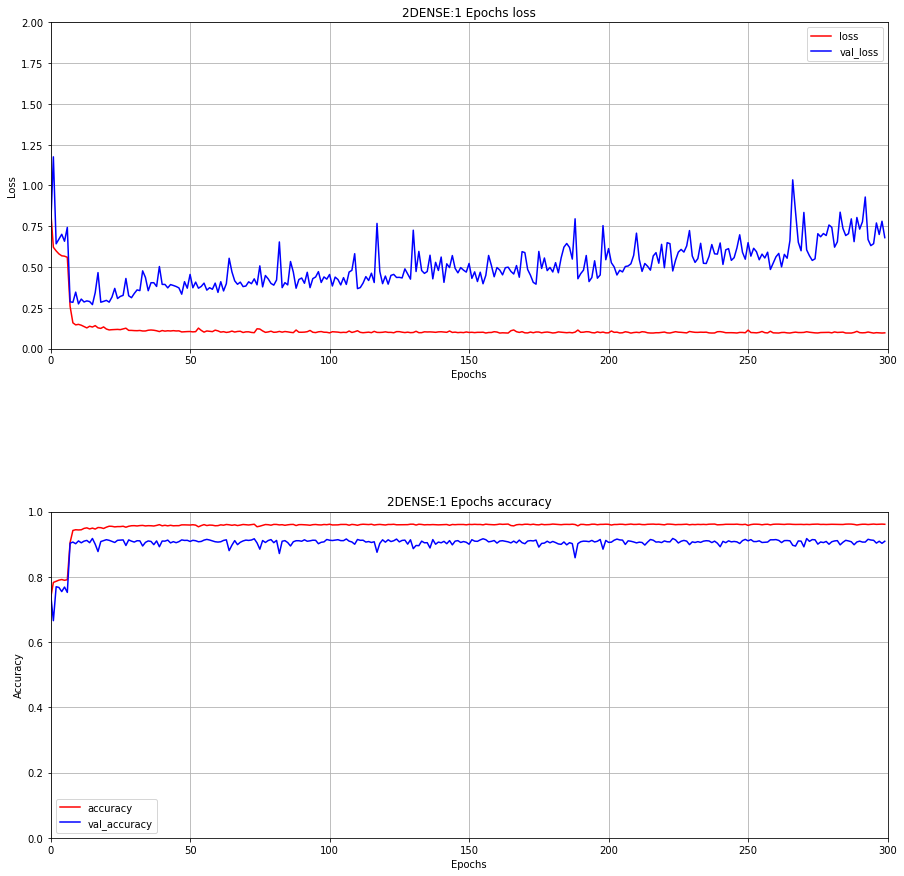

In [56]:
#print out plots and results
g = GenerateResults #create the plot generator

save_dir = '/saved_data/'
result_dir = '3CNN_2DENSE-tests-1_filters-128_kernel-3_dropout-0.5_epochs-300_dense-128_activation-relu/'
pickle_files = os.listdir(colab_folder + save_dir + result_dir)
for f in pickle_files:
    imported_data_name = f'{colab_folder}{save_dir}{result_dir}' + f
    imported_data = pickle.load(open(imported_data_name, 'rb'))
    
    f_no_ext = ".".join(f.split('.')[0:-1])
    
    for d in imported_data:
      title = f_no_ext.split('_')[1]
      sub_title = f"{title}:{d[0].get('test parameter')}"
      g.plot_histogram(d[0].get('history'), f'{sub_title} Epochs', save_name=(f_no_ext + f"_{d[0].get('test parameter')}"), save_dir=result_dir)
    #g.plot_results(imported_data, title, save_name=f_no_ext, save_dir=result_dir)
    #g.print_results(imported_data, display_name)